In [56]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [57]:
raw_data = pd.read_csv('cleansed_data//all_consumption_metadata.csv', index_col=0, parse_dates=True,
                      dtype={'loc_id':'str', 'consumption_kvah':'float32', 'temperature':'float32', 
                             'el_price':'float32', 'oil_price':'float32'})
raw_data.head()

,loc_id,consumption_kvah,temperature,el_price,oil_price
time,,,,,
2018-01-01 00:00:00,0,27.0,5.5,26.330000,66.730003
2018-01-01 01:00:00,0,27.5,5.0,26.430000,66.730003
2018-01-01 02:00:00,0,27.0,4.8,26.100000,66.730003
2018-01-01 03:00:00,0,23.0,4.9,24.700001,66.730003
2018-01-01 04:00:00,0,23.0,3.7,24.740000,66.730003


In [478]:
grped = raw_data[['consumption_kvah', 'temperature', 'loc_id', 'oil_price', 'el_price']].groupby(by=['loc_id', raw_data.index.month]).mean()

mx, mn = (max(grped['el_price']), min(grped['el_price']))
grped['el_price'] = (grped['el_price'] - mn) / (mx - mn)

mx, mn = (max(grped['oil_price']), min(grped['oil_price']))
grped['oil_price'] = (grped['oil_price'] - mn) / (mx - mn)

In [479]:
app = pd.DataFrame(columns=['consumption_kvah', 'temperature', 'oil_price', 'el_price', 'month', 'loc_id'])
normalized_features = ['consumption_kvah', 'temperature']

i = 0

for l in grped.index.get_level_values(0).unique(): 
    temp = grped.loc[l].copy()
    temp['month'] = temp.index
    temp['loc_id'] = l
    n = len(temp)
    temp.index = (range(i, i+n))
    
    for f in normalized_features:
        mx, mn = (max(temp[f]), min(temp[f]))
        temp[f] = (temp[f] - mn) / (mx-mn)
    app = app.append(temp)
    i += n

In [480]:
import seaborn as sns
from matplotlib import rcParams
rcParams["legend.markerscale"] = 2.5

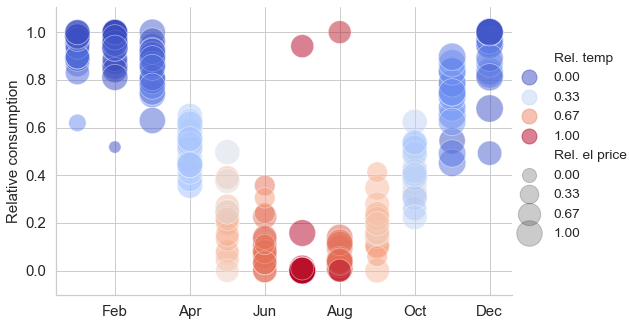

In [483]:
sns.set(font_scale=1.25)
sns.set_style("whitegrid")
g = sns.relplot(x="month", y="consumption_kvah",
                     hue="temperature",
                     hue_norm=(0,1),
                     palette='coolwarm',
                     size='el_price',
                     sizes=(150,750),
                     alpha=0.5,
                     height=5,
                     aspect=1.5,
                     legend='brief',
                     kind='scatter',
                     edgecolor='White',
                     data=app.sort_values('loc_id'))

g._legend.set_title("")
g._legend.set_bbox_to_anchor([0.98, 0.5])  # coordinates of lower left of bounding box
g._legend._loc = 5
new_labels = ['Rel. temp    ', '0.00', '0.33', '0.67', '1.00',
             'Rel. el price   ', '0.00', '0.33', '0.67', '1.00']

j = 0
for i, (t, h, l) in enumerate(zip(g._legend.texts, g._legend.legendHandles, new_labels)): 
    t.set_text(l)
    h.set_alpha(0.5)
    
    if i > 5: 
        h.set_alpha(0.25)
        h._sizes = [200 + j*150]
        j += 1
        
g.set(facecolor='white')
#plt.title('Mean relative power consumption per month for each sample customer', size=17)
plt.ylabel('Relative consumption', size=15)
plt.xlabel('', size=15)

plt.yticks(size=15)
plt.xticks(ticks=[i for i in range(2,13,2)], labels=['Feb', 'Apr', 'Jun', 'Aug', 'Oct', 'Dec'], size=15)
plt.grid(True, axis='both')
g.savefig('data_cube.png', pad_inces=-5)
plt.show()

## Resample weeks

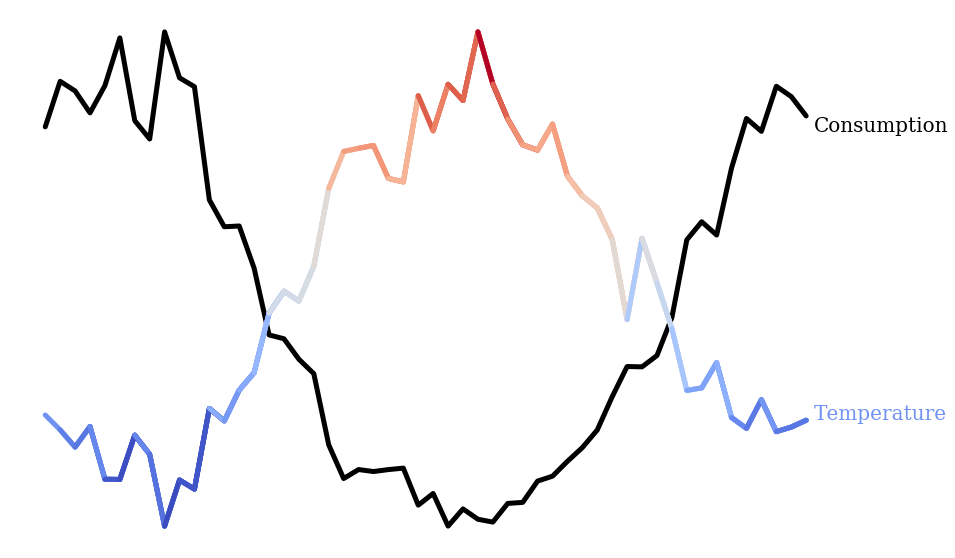

In [477]:
sub = app[app['loc_id']=='18']

rcParams['font.family'] = 'serif'
fig, ax = plt.subplots(1,1, figsize=(15,10))

ax.plot(sub.consumption_kvah, lw=5, c='black')

colors = plt.cm.coolwarm(sub.temperature)
for i in range(len(sub)): ax.plot(sub.iloc[i:i+5].temperature, lw=5, c=colors[i])

for line, name in zip(ax.lines, ['Consumption', 'Temperature']):
    y = line.get_ydata()[0]
    ax.annotate(name, xy=(1,y), xytext=(-30,0), color=line.get_color(), 
                xycoords = ax.get_yaxis_transform(), textcoords="offset points",
                size=20, va="center")
    
ax.axis('off')
fig.figsize = (20,10)
fig.savefig('front.png', pad_inces=-5)
plt.show()